Windy Gridworld - SARSA Implementation


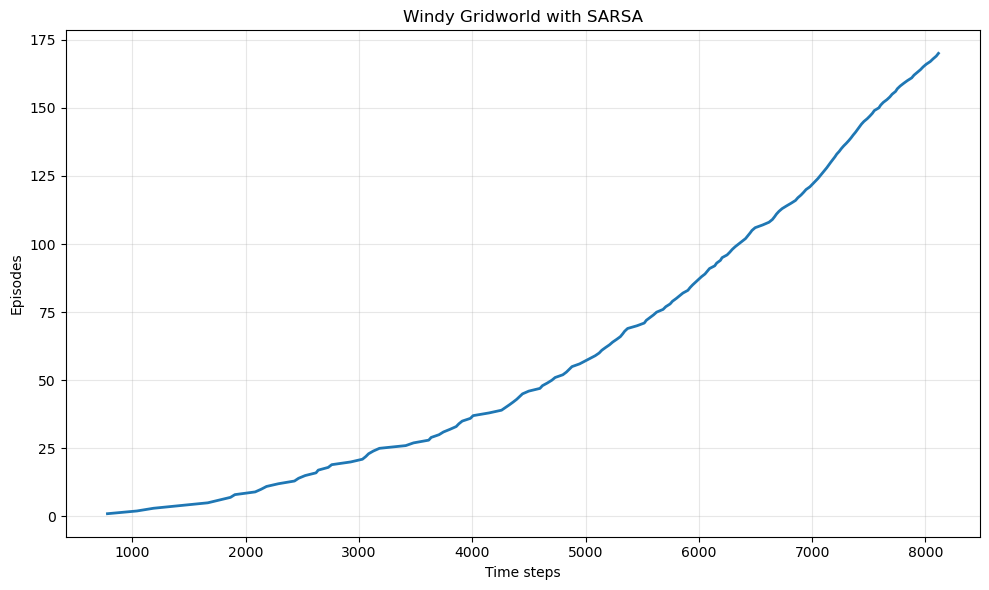

In [1]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Example 6.5
# Implementation of SARSA (on-policy TD control) for the Windy Gridworld problem
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt

class WindyGrid:
    """
    environment for the windy gridworld problem.
    agent starts at one side and needs to reach the goal on the other side.
    there's wind in the middle columns that pushes the agent upward.
    """
    
    def __init__(self):
        # setup grid size
        self.height = 7
        self.width = 10
        
        # starting position and goal position (using row, col format)
        self.start = (3, 0)
        self.goal = (3, 7)
        
        # wind strength in each column - this pushes agent up
        # the middle columns have stronger wind
        self.wind_strength = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        
        # possible actions
        self.action_list = ['UP', 'DOWN', 'RIGHT', 'LEFT']
        
        # where we are right now
        self.position = None
    
    def reset_position(self):
        """go back to starting position"""
        self.position = self.start
        return self.position
    
    def take_action(self, action):
        """
        move the agent based on action and wind.
        """
        r, c = self.position
        
        # figure out where action takes us
        if action == 'UP':
            r = r - 1
        elif action == 'DOWN':
            r = r + 1
        elif action == 'RIGHT':
            c = c + 1
        elif action == 'LEFT':
            c = c - 1
        
        # now apply wind effect (wind pushes up, so subtract from row)
        wind = self.wind_strength[self.position[1]]  # use old column for wind
        r = r - wind
        
        # make sure we stay inside the grid
        if r < 0:
            r = 0
        if r >= self.height:
            r = self.height - 1
        if c < 0:
            c = 0
        if c >= self.width:
            c = self.width - 1
        
        # update position
        self.position = (r, c)
        
        # check if we reached goal
        finished = (self.position == self.goal)
        
        # always get -1 reward (we want to minimize steps)
        reward = -1
        
        return self.position, reward, finished


def pick_action(q_values, state, eps, actions):
    """
    epsilon-greedy action selection.
    """
    # explore with probability epsilon
    if np.random.rand() < eps:
        return np.random.choice(actions)
    
    # otherwise exploit - pick best action
    # first get q values for all actions from current state
    action_values = []
    for a in actions:
        action_values.append(q_values.get((state, a), 0.0))
    
    # find max value
    best_value = max(action_values)
    
    # there might be ties, so collect all best actions
    best_actions = []
    for i, a in enumerate(actions):
        if action_values[i] == best_value:
            best_actions.append(a)
    
    # pick randomly among best
    return np.random.choice(best_actions)


def run_sarsa(environment, n_episodes, step_size=0.5, discount=1.0, eps=0.1):
    """
    main SARSA algorithm implementation.
    this learns from the actions actually taken (on-policy).
    """
    
    # initialize q-values to zero
    q_vals = {}
    
    # keep track of how long each episode takes
    steps_per_episode = []
    total_steps_so_far = []
    steps_count = 0
    
    # run for specified number of episodes
    for ep in range(n_episodes):
        # start episode
        state = environment.reset_position()
        
        # pick first action using epsilon-greedy
        action = pick_action(q_vals, state, eps, environment.action_list)
        
        episode_steps = 0
        
        # keep going until we reach the goal
        done = False
        while not done:
            # take the action
            next_state, reward, done = environment.take_action(action)
            
            episode_steps += 1
            steps_count += 1
            
            # if we're at goal, do final update
            if done:
                current_q = q_vals.get((state, action), 0.0)
                q_vals[(state, action)] = current_q + step_size * (reward - current_q)
                break
            
            # pick next action from next state
            next_action = pick_action(q_vals, next_state, eps, environment.action_list)
            
            # SARSA update - uses the actual next action we'll take
            current_q = q_vals.get((state, action), 0.0)
            next_q = q_vals.get((next_state, next_action), 0.0)
            target = reward + discount * next_q
            q_vals[(state, action)] = current_q + step_size * (target - current_q)
            
            # move to next state and action
            state = next_state
            action = next_action
        
        # record episode info
        steps_per_episode.append(episode_steps)
        total_steps_so_far.append(steps_count)
    
    return q_vals, steps_per_episode, total_steps_so_far


def make_plot(timesteps, episodes):
    """Create the plot"""
    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, episodes, linewidth=2)
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')
    plt.title('Windy Gridworld with SARSA')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('sarsa_results.png', dpi=150)
    plt.show()


def test_policy(environment, q_vals):
    """
    test what the learned policy does.
    follow greedy policy (no exploration) from start to goal.
    """
    state = environment.reset_position()
    path = [state]
    
    for step in range(50):  # max 50 steps to avoid infinite loop
        if state == environment.goal:
            break
        
        # pick best action (greedy, eps=0)
        action = pick_action(q_vals, state, 0.0, environment.action_list)
        state, _, _ = environment.take_action(action)
        path.append(state)
    
    return path


if __name__ == "__main__":
    print("="*50)
    print("Windy Gridworld - SARSA Implementation")
    print("="*50)
    
    # set random seed for reproducibility
    np.random.seed(123)
    
    # parameters
    num_episodes = 170
    learning_rate = 0.5
    gamma = 1.0
    epsilon = 0.1
    
    # create environment and run SARSA
    env = WindyGrid()
    #print("Running SARSA algorithm...")
    
    q_values, episode_lengths, cumulative_steps = run_sarsa(
        env, num_episodes, learning_rate, gamma, epsilon
    )
    
    
    # test the learned policy
    #learned_path = test_policy(env, q_values)
    
    # make the plot
    episode_numbers = list(range(1, num_episodes + 1))
    make_plot(cumulative_steps, episode_numbers)